In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum",token='92264b2dc22178be65f58149e1b4e6e6e2ecb51136e95c8c0c4f7b146c85085566aca8cb80e96d0749f6e0683d2f83d374f0908acd6e6e31111e3d7d4003144b')
backend = service.least_busy(operational=True, simulator=False)

In [4]:
import sys
sys.path.append(r'C:\Users\harsh\quactography')
from quactography.hamiltonian.hamiltonian_total import Hamiltonian
from quactography.adj_matrix.io import load_graph 
from quactography.graph.undirected_graph import Graph


weighted_graph, _, _ = load_graph(r"C:\Users\harsh\quactography\scripts\rand_graph.npz")
graph = Graph(weighted_graph, 1, 2)
hamiltonian = Hamiltonian(graph, 2) 
pauli_chain_hamiltonian = hamiltonian.total_hamiltonian
pauli_chain_hamiltonian

SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIII', 'IIZIII', 'IZIIII', 'IIIIIZ', 'IZZIII', 'IIZIIZ', 'IZIIIZ', 'IIIIZI', 'ZIIIII', 'IIZIZI', 'ZIIIZI', 'ZIZIII', 'IIIZZZ', 'ZZIZII'],
              coeffs=[-5. +0.j,  1. -0.j,  0.5-0.j,  1.5-0.j,  1. -0.j,  0.5-0.j,  0.5-0.j,
 12. +0.j, -2. +0.j, -1. +0.j, -1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
 -1. +0.j, -1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j, -4. +0.j, -4. +0.j])

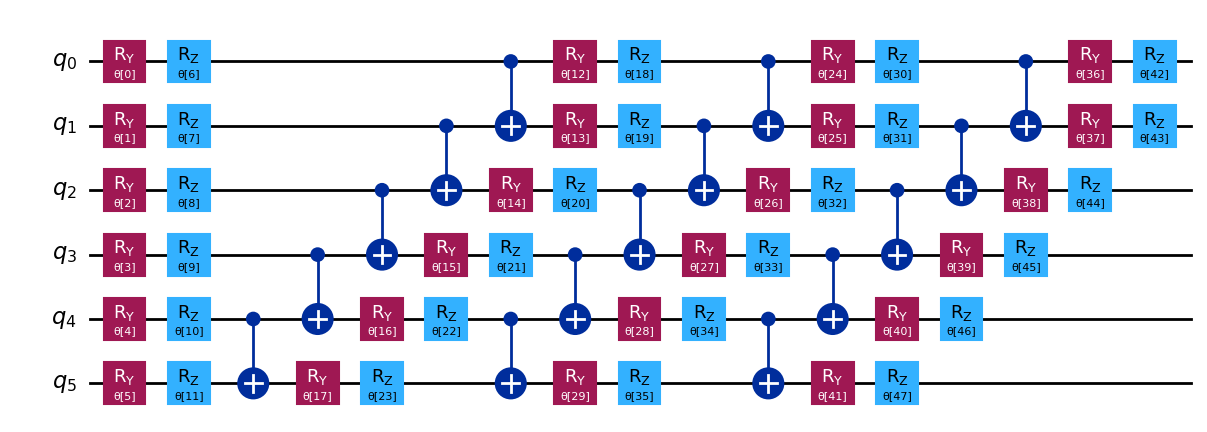

In [5]:
ansatz = EfficientSU2(graph.number_of_edges)
ansatz.decompose().draw("mpl", style='iqp')

In [6]:
num_params = ansatz.num_parameters
num_params

48

### Step 2: Optimize for quantum execution

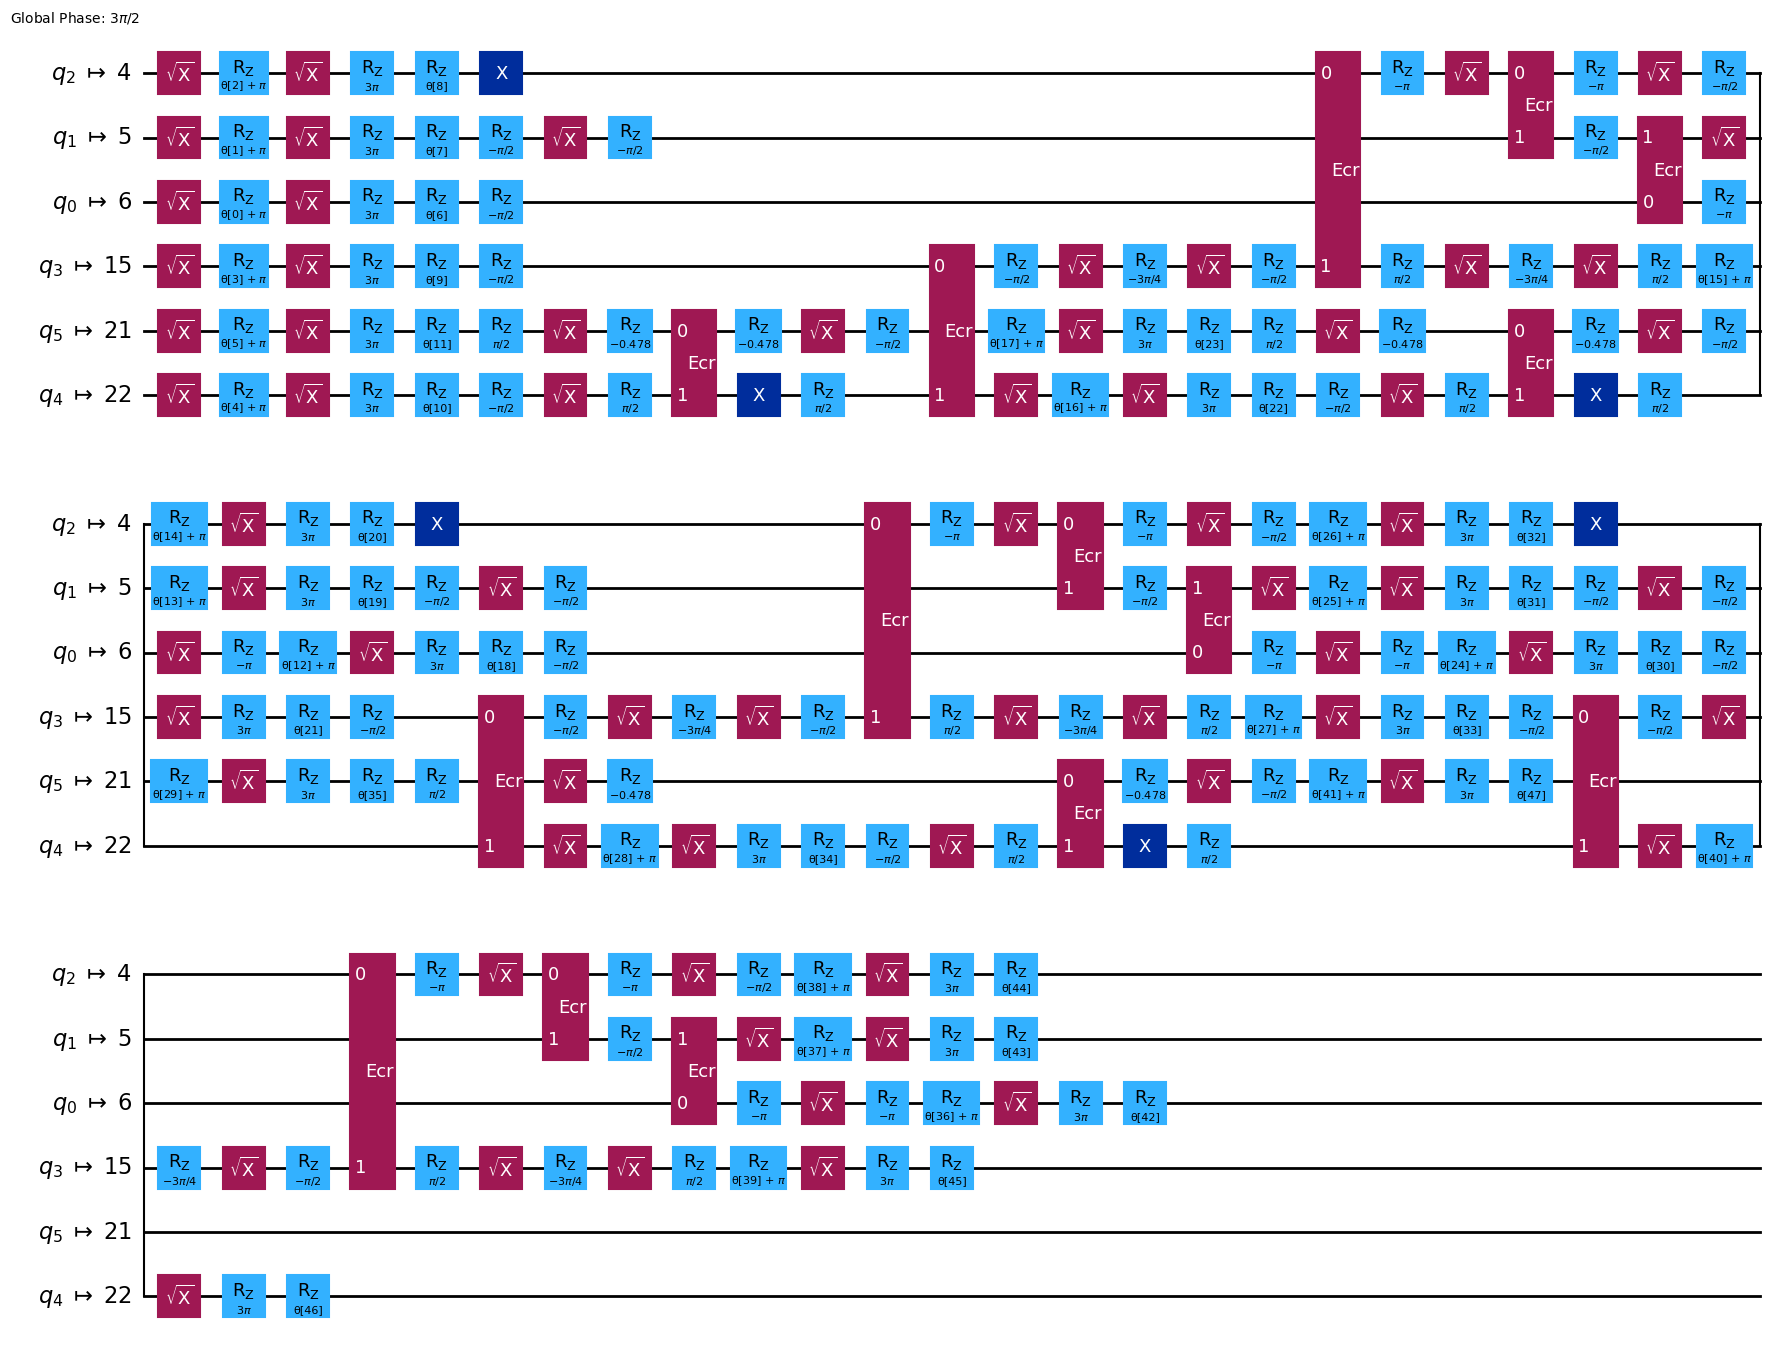

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

target = backend.target 
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output='mpl', idle_wires = False, style = 'iqp')

In [8]:
hamiltonian_isa = pauli_chain_hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [9]:
def cost_func(params, ansatz, pauli_chain_hamiltonian, estimator,cost_history_dict):
    pub = (ansatz, pauli_chain_hamiltonian, [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    
    cost_history_dict['iters'] +=1 
    cost_history_dict['prev_vector'] = params 
    cost_history_dict['cost_history'].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]") 
    
    return energy   
    

In [10]:
cost_history_dict = {"prev_vector": None,
                     "iters":0,
                     "cost_history":[],
                     }

In [11]:
x0 = 2*np.pi*np.random.random(num_params)
x0

array([0.12208335, 1.0246496 , 1.93994463, 5.31987092, 6.26273054,
       2.72910944, 0.21684289, 5.29300955, 0.38136462, 4.61300721,
       5.75691322, 5.34645442, 3.4663805 , 4.29240866, 0.75459046,
       2.14436787, 1.44707178, 6.11364942, 1.45276531, 1.21831496,
       3.28160608, 0.39999126, 1.67493375, 1.51908679, 2.74282101,
       0.30901949, 0.84799428, 0.68928151, 2.83906809, 0.46935368,
       1.26760736, 2.80126084, 4.51337377, 1.8528518 , 0.70334439,
       4.24214408, 1.31317622, 5.69381842, 1.59499766, 2.88715118,
       2.71076736, 4.76713099, 5.85297872, 1.9653244 , 2.51230018,
       0.20704099, 2.93141629, 5.4578021 ])

In [16]:
with Session(backend=backend) as session: 
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000 # type: ignore
    
    res = minimize(
        cost_func,
        x0,
        args = (ansatz_isa, hamiltonian_isa,estimator, cost_history_dict),
        method = "cobyla",
    )
    

C:\Users\harsh\AppData\Local\Temp\ipykernel_48976\4024226428.py:2: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


In [ ]:
res

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
import qiskit_ibm_runtime 

qiskit_ibm_runtime.version.get_version_info(
)

In [ ]:
import qiskit

qiskit.version.get_version_info()